<a href="https://colab.research.google.com/github/Chetalispatil/Product_Analysis/blob/main/Product_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk textblob scikit-learn imbalanced-learn matplotlib seaborn wordcloud


In [ ]:
!pip install -q transformers torch torchvision torchaudio
!pip install -q datasets accelerate
!pip install -q fastapi uvicorn pyngrok nest-asyncio
!pip install -q beautifulsoup4 requests lxml html5lib fake-useragent
!pip install -q pandas numpy matplotlib seaborn wordcloud
!pip install -q scikit-learn nltk textblob spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 107.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:


# Standard libraries
import os
import re
import json
import warnings
import requests
from typing import List, Dict, Optional
from datetime import datetime
from collections import Counter
import time
import nest_asyncio
nest_asyncio.apply()

warnings.filterwarnings('ignore')

# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP
import nltk
import spacy
from textblob import TextBlob

# Transformers
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline
)

# Web scraping
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

# API
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import Optional, List

# Download NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    pass

# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("⚠️ SpaCy model not loaded. Run: !python -m spacy download en_core_web_sm")
    nlp = None

print("✅ All imports successful!")

✅ All imports successful!


In [ ]:
class ProductReviewScraper:
    """Universal scraper for product reviews from e-commerce sites"""

    def __init__(self):
        self.ua = UserAgent()
        self.session = requests.Session()
        self.headers = {
            'User-Agent': self.ua.random,
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'DNT': '1',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1'
        }

    def identify_platform(self, url: str) -> str:
        """Identify e-commerce platform"""
        url_lower = url.lower()
        if 'amazon' in url_lower:
            return 'amazon'
        elif 'flipkart' in url_lower:
            return 'flipkart'
        elif 'ebay' in url_lower:
            return 'ebay'
        else:
            return 'generic'

    def scrape_amazon_reviews(self, product_url: str, max_reviews: int = 50) -> pd.DataFrame:
        """Scrape Amazon product reviews"""
        try:
            # Extract ASIN from URL
            asin_match = re.search(r'/dp/([A-Z0-9]{10})', product_url)
            if not asin_match:
                asin_match = re.search(r'/product/([A-Z0-9]{10})', product_url)

            if not asin_match:
                print("❌ Could not extract ASIN from URL")
                return self._get_demo_data()

            asin = asin_match.group(1)
            print(f"✓ Found ASIN: {asin}")

            # Construct review URL
            base_url = "https://www.amazon.in"
            if "amazon.com" in product_url.lower():
                base_url = "https://www.amazon.com"

            review_url = f"{base_url}/product-reviews/{asin}"
            reviews_data = []
            page = 1

            while len(reviews_data) < max_reviews and page <= 5:
                try:
                    print(f"→ Scraping page {page}...")

                    params = {'pageNumber': page}
                    response = self.session.get(
                        review_url,
                        headers=self.headers,
                        params=params,
                        timeout=15
                    )

                    if response.status_code != 200:
                        print(f"⚠️ Page {page} returned status {response.status_code}")
                        break

                    soup = BeautifulSoup(response.content, 'html.parser')

                    # Find review containers
                    reviews = soup.find_all('div', {'data-hook': 'review'})

                    if not reviews:
                        print(f"⚠️ No reviews found on page {page}")
                        break

                    for review in reviews:
                        try:
                            # Extract rating
                            rating_elem = review.find('i', {'data-hook': 'review-star-rating'})
                            if not rating_elem:
                                rating_elem = review.find('i', class_='a-icon-star')

                            rating = None
                            if rating_elem:
                                rating_text = rating_elem.get_text().strip()
                                rating_match = re.search(r'(\d+\.?\d*)', rating_text)
                                if rating_match:
                                    rating = float(rating_match.group(1))

                            # Extract title
                            title_elem = review.find('a', {'data-hook': 'review-title'})
                            if not title_elem:
                                title_elem = review.find('span', {'data-hook': 'review-title'})
                            title = title_elem.get_text().strip() if title_elem else ''

                            # Extract review text
                            text_elem = review.find('span', {'data-hook': 'review-body'})
                            text = text_elem.get_text().strip() if text_elem else ''

                            # Extract date
                            date_elem = review.find('span', {'data-hook': 'review-date'})
                            date = date_elem.get_text().strip() if date_elem else ''

                            # Extract verified purchase
                            verified = review.find('span', {'data-hook': 'avp-badge'}) is not None

                            # Only add if we have essential data
                            if text and rating:
                                reviews_data.append({
                                    'rating': rating,
                                    'title': title,
                                    'review_text': text,
                                    'date': date,
                                    'verified': verified,
                                    'platform': 'Amazon'
                                })

                        except Exception as e:
                            print(f"⚠️ Error parsing single review: {str(e)[:50]}")
                            continue

                    page += 1
                    time.sleep(1)  # Be polite to servers

                except Exception as e:
                    print(f"⚠️ Error on page {page}: {str(e)[:50]}")
                    break

            if not reviews_data:
                print("❌ No reviews scraped. Using demo data.")
                return self._get_demo_data()

            df = pd.DataFrame(reviews_data)
            print(f"✅ Scraped {len(df)} reviews from Amazon")
            return df

        except Exception as e:
            print(f"❌ Error scraping Amazon: {str(e)[:100]}")
            print("→ Using demo data instead.")
            return self._get_demo_data()

    def scrape_reviews(self, product_url: str, max_reviews: int = 50) -> pd.DataFrame:
        """Main method to scrape reviews"""
        platform = self.identify_platform(product_url)
        print(f"📱 Detected platform: {platform.upper()}")

        if platform == 'amazon':
            return self.scrape_amazon_reviews(product_url, max_reviews)
        else:
            print("⚠️ Platform not fully supported. Using demo data.")
            return self._get_demo_data()

    def _get_demo_data(self) -> pd.DataFrame:
        """Generate demo data for testing"""
        demo_reviews = [
            {
                'rating': 5.0,
                'title': 'Excellent Product!',
                'review_text': 'This product exceeded my expectations. The quality is outstanding and delivery was super fast. Highly recommended for everyone!',
                'verified': True,
                'platform': 'Demo',
                'date': 'January 15, 2025'
            },
            {
                'rating': 4.0,
                'title': 'Good value for money',
                'review_text': 'Pretty good product overall. The build quality is solid and it works exactly as described. Minor issues with packaging but nothing major.',
                'verified': True,
                'platform': 'Demo',
                'date': 'January 20, 2025'
            },
            {
                'rating': 2.0,
                'title': 'Disappointed with quality',
                'review_text': 'The product quality is poor compared to the price. It stopped working after just a week. Customer service was unhelpful when I contacted them.',
                'verified': True,
                'platform': 'Demo',
                'date': 'January 22, 2025'
            },
            {
                'rating': 1.0,
                'title': 'Complete waste of money',
                'review_text': 'Terrible product. Completely broken on arrival and packaging was damaged. Do not buy this product. Save your hard-earned money.',
                'verified': False,
                'platform': 'Demo',
                'date': 'January 25, 2025'
            },
            {
                'rating': 3.0,
                'title': 'Average product, nothing special',
                'review_text': 'Its okay, nothing special about this product. Does the basic job but there are definitely better options available in the market.',
                'verified': True,
                'platform': 'Demo',
                'date': 'January 28, 2025'
            },
            {
                'rating': 5.0,
                'title': 'Amazing quality!',
                'review_text': 'Best purchase I made this year. The design is beautiful and performance is excellent. Fast delivery and great customer service too!',
                'verified': True,
                'platform': 'Demo',
                'date': 'February 1, 2025'
            },
            {
                'rating': 4.0,
                'title': 'Satisfied customer',
                'review_text': 'Good product with nice features. The price point is reasonable and quality is good. Would recommend to friends and family.',
                'verified': True,
                'platform': 'Demo',
                'date': 'February 3, 2025'
            },
            {
                'rating': 1.0,
                'title': 'Very disappointed',
                'review_text': 'Poor quality materials. Broke within days. Customer support did not respond to emails. Complete waste of time and money.',
                'verified': True,
                'platform': 'Demo',
                'date': 'February 5, 2025'
            }
        ]
   # Extend to reach desired number
        extended_reviews = []
        while len(extended_reviews) < 50:
            extended_reviews.extend(demo_reviews)

        return pd.DataFrame(extended_reviews[:50])




In [ ]:
# ============================================================================
# PART 4: BERT SENTIMENT ANALYZER
# ============================================================================

class BERTSentimentAnalyzer:
    """Advanced sentiment analysis using BERT transformers"""

    def __init__(self, model_name='nlptown/bert-base-multilingual-uncased-sentiment'):
        print("🔄 Loading BERT model...")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"→ Using device: {self.device}")

        try:
            # Load pre-trained model
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
            self.model.to(self.device)
            self.model.eval()

            # Create pipeline
            self.sentiment_pipeline = pipeline(
                "sentiment-analysis",
                model=self.model,
                tokenizer=self.tokenizer,
                device=0 if torch.cuda.is_available() else -1,
                truncation=True,
                max_length=512
            )

            print("✅ BERT model loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading BERT model: {e}")
            raise

    def predict_sentiment(self, text: str) -> Dict:
        """Predict sentiment for a single text"""
        try:
            # Truncate text to avoid token limit issues
            text = text[:512] if len(text) > 512 else text

            result = self.sentiment_pipeline(text)[0]

            # Extract star rating from label
            label = result['label']
            score = result['confidence'] if 'confidence' in result else result['score']

            # Parse stars from label (format: "X stars")
            stars_match = re.search(r'(\d+)', label)
            stars = int(stars_match.group(1)) if stars_match else 3

            # Map to sentiment
            if stars >= 4:
                sentiment = 'Positive'
            elif stars <= 2:
                sentiment = 'Negative'
            else:
                sentiment = 'Neutral'

            return {
                'text': text[:100] + '...' if len(text) > 100 else text,
                'sentiment': sentiment,
                'stars': stars,
                'confidence': float(score)
            }

        except Exception as e:
            print(f"⚠️ Error in prediction: {e}")
            return {
                'text': text[:100] if text else '',
                'sentiment': 'Neutral',
                'stars': 3,
                'confidence': 0.5
            }

    def batch_predict(self, texts: List[str], batch_size: int = 8) -> List[Dict]:
        """Predict sentiment for multiple texts"""
        results = []
        total = len(texts)

        print(f"🔄 Analyzing {total} reviews...")
        for i in range(0, total, batch_size):
            batch = texts[i:i+batch_size]
            for text in batch:
                results.append(self.predict_sentiment(text))

            if (i + batch_size) % 20 == 0:
                print(f"→ Processed {min(i + batch_size, total)}/{total} reviews")

        print("✅ Batch prediction complete!")
        return results

In [ ]:
class AspectBasedSentimentAnalyzer:
    """Extract aspects from reviews and analyze sentiment for each aspect"""

    def __init__(self):
        self.nlp = nlp

        # Common product aspects
        self.aspects = {
            'quality': ['quality', 'build', 'material', 'durability', 'construction', 'made', 'sturdy'],
            'price': ['price', 'cost', 'value', 'expensive', 'cheap', 'affordable', 'worth', 'money'],
            'delivery': ['delivery', 'shipping', 'packaging', 'package', 'arrived', 'received', 'delivered'],
            'performance': ['performance', 'works', 'working', 'speed', 'fast', 'slow', 'efficient', 'effective'],
            'design': ['design', 'look', 'appearance', 'color', 'style', 'aesthetic', 'beautiful', 'ugly'],
            'service': ['service', 'support', 'customer', 'help', 'response', 'helpful'],
            'features': ['feature', 'functionality', 'option', 'capability', 'functions']
        }

    def extract_aspects(self, text: str) -> List[str]:
        """Extract aspects mentioned in the text"""
        text_lower = text.lower()
        found_aspects = []

        for aspect, keywords in self.aspects.items():
            for keyword in keywords:
                if keyword in text_lower:
                    found_aspects.append(aspect)
                    break

        return list(set(found_aspects))

    def get_aspect_sentences(self, text: str, aspect: str) -> List[str]:
        """Get sentences that mention a specific aspect"""
        if not self.nlp:
            # Fallback if spaCy not loaded
            sentences = text.split('.')
        else:
            doc = self.nlp(text)
            sentences = [sent.text.strip() for sent in doc.sents]

        aspect_keywords = self.aspects.get(aspect, [])

        relevant_sentences = []
        for sentence in sentences:
            sentence_lower = sentence.lower()
            if any(keyword in sentence_lower for keyword in aspect_keywords):
                relevant_sentences.append(sentence)

        return relevant_sentences

    def analyze_aspect_sentiment(self, text: str, bert_analyzer) -> Dict:
        """Analyze sentiment for each aspect in the text"""
        aspects = self.extract_aspects(text)
        aspect_sentiments = {}

        for aspect in aspects:
            sentences = self.get_aspect_sentences(text, aspect)
            if sentences:
                # Analyze sentiment of aspect-related sentences
                combined_text = ' '.join(sentences)
                sentiment_result = bert_analyzer.predict_sentiment(combined_text)
                aspect_sentiments[aspect] = {
                    'sentiment': sentiment_result['sentiment'],
                    'confidence': sentiment_result['confidence'],
                    'mentions': sentences[:2]  # First 2 mentions
                }

        return aspect_sentiments

    def analyze_reviews_aspects(self, df: pd.DataFrame, bert_analyzer) -> pd.DataFrame:
        """Analyze aspects for all reviews"""
        print("🔄 Analyzing aspects for all reviews...")

        aspect_data = []
        total = len(df)

        for idx, row in df.iterrows():
            text = row['review_text']
            aspects = self.analyze_aspect_sentiment(text, bert_analyzer)

            aspect_data.append({
                'review_index': idx,
                'aspects': aspects,
                'num_aspects': len(aspects)
            })

            if (idx + 1) % 10 == 0:
                print(f"→ Analyzed {idx + 1}/{total} reviews")

        print("✅ Aspect analysis complete!")
        return pd.DataFrame(aspect_data)

In [ ]:
def create_visualizations(df_reviews, df_aspects):
    """Create comprehensive visualizations"""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Sentiment Distribution Pie Chart
    ax1 = fig.add_subplot(gs[0, 0])
    sentiment_counts = df_reviews['bert_sentiment'].value_counts()
    colors = {'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Neutral': '#95a5a6'}
    sentiment_colors = [colors.get(s, '#3498db') for s in sentiment_counts.index]
    ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=sentiment_colors, startangle=90)
    ax1.set_title('Sentiment Distribution', fontsize=12, fontweight='bold')

    # 2. Rating vs Sentiment
    ax2 = fig.add_subplot(gs[0, 1])
    rating_sentiment = pd.crosstab(df_reviews['rating'], df_reviews['bert_sentiment'])
    rating_sentiment.plot(kind='bar', ax=ax2, color=['#e74c3c', '#95a5a6', '#2ecc71'])
    ax2.set_title('Rating vs BERT Sentiment', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Rating')
    ax2.set_ylabel('Count')
    ax2.legend(title='Sentiment', loc='upper left')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

    # 3. Confidence Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(df_reviews['bert_confidence'], bins=20, color='#3498db', alpha=0.7, edgecolor='black')
    ax3.set_title('BERT Confidence Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Confidence Score')
    ax3.set_ylabel('Frequency')
    mean_conf = df_reviews['bert_confidence'].mean()
    ax3.axvline(mean_conf, color='red', linestyle='--',
                label=f'Mean: {mean_conf:.3f}')
    ax3.legend()

    # 4. Aspect Frequency
    ax4 = fig.add_subplot(gs[1, :])
    all_aspects = []
    for aspects_dict in df_aspects['aspects']:
        if isinstance(aspects_dict, dict):
            all_aspects.extend(aspects_dict.keys())

    if all_aspects:
        aspect_counts = pd.Series(all_aspects).value_counts()
        aspect_counts.plot(kind='barh', ax=ax4, color='#9b59b6')
        ax4.set_title('Most Discussed Aspects', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Frequency')
        ax4.set_ylabel('Aspect')
    else:
        ax4.text(0.5, 0.5, 'No aspects found', ha='center', va='center')
        ax4.set_title('Most Discussed Aspects', fontsize=12, fontweight='bold')

    # 5. Positive Reviews Word Cloud
    ax5 = fig.add_subplot(gs[2, 0])
    positive_reviews = df_reviews[df_reviews['bert_sentiment'] == 'Positive']
    if len(positive_reviews) > 0:
        positive_text = ' '.join(positive_reviews['review_text'].astype(str))
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                             colormap='Greens', max_words=50).generate(positive_text)
        ax5.imshow(wordcloud, interpolation='bilinear')
    else:
        ax5.text(0.5, 0.5, 'No positive reviews', ha='center', va='center')
    ax5.set_title('Positive Reviews Word Cloud', fontsize=12, fontweight='bold')
    ax5.axis('off')

    # 6. Negative Reviews Word Cloud
    ax6 = fig.add_subplot(gs[2, 1])
    negative_reviews = df_reviews[df_reviews['bert_sentiment'] == 'Negative']
    if len(negative_reviews) > 0:
        negative_text = ' '.join(negative_reviews['review_text'].astype(str))
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                             colormap='Reds', max_words=50).generate(negative_text)
        ax6.imshow(wordcloud, interpolation='bilinear')
    else:
        ax6.text(0.5, 0.5, 'No negative reviews', ha='center', va='center')
    ax6.set_title('Negative Reviews Word Cloud', fontsize=12, fontweight='bold')
    ax6.axis('off')

    # 7. Sentiment by Platform
    ax7 = fig.add_subplot(gs[2, 2])
    if 'platform' in df_reviews.columns:
        platform_sentiment = pd.crosstab(df_reviews['platform'], df_reviews['bert_sentiment'])
        platform_sentiment.plot(kind='bar', ax=ax7, color=['#e74c3c', '#95a5a6', '#2ecc71'])
        ax7.set_title('Sentiment by Platform', fontsize=12, fontweight='bold')
        ax7.set_xlabel('Platform')
        ax7.set_ylabel('Count')
        ax7.legend(title='Sentiment', loc='upper left')
        plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45)

    plt.suptitle('🎯 Product Review Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    print("✅ Visualizations created!")

In [ ]:
class ReviewAnalytics:
    """Generate statistical insights from reviews"""

    def __init__(self, df_reviews, df_aspects):
        self.df_reviews = df_reviews
        self.df_aspects = df_aspects

    def get_overall_statistics(self) -> Dict:
        """Calculate overall statistics"""
        stats = {
            'total_reviews': len(self.df_reviews),
            'average_rating': self.df_reviews['rating'].mean(),
            'median_rating': self.df_reviews['rating'].median(),
            'sentiment_distribution': self.df_reviews['bert_sentiment'].value_counts().to_dict(),
            'positive_percentage': (self.df_reviews['bert_sentiment'] == 'Positive').mean() * 100,
            'negative_percentage': (self.df_reviews['bert_sentiment'] == 'Negative').mean() * 100,
            'neutral_percentage': (self.df_reviews['bert_sentiment'] == 'Neutral').mean() * 100,
            'average_confidence': self.df_reviews['bert_confidence'].mean(),
            'verified_reviews': self.df_reviews['verified'].sum() if 'verified' in self.df_reviews.columns else 0
        }
        return stats

    def get_aspect_statistics(self) -> Dict:
        """Calculate aspect-level statistics"""
        all_aspects = []
        aspect_sentiments = {'Positive': [], 'Negative': [], 'Neutral': []}

        for aspects_dict in self.df_aspects['aspects']:
            if isinstance(aspects_dict, dict):
                for aspect, details in aspects_dict.items():
                    all_aspects.append(aspect)
                    if isinstance(details, dict) and 'sentiment' in details:
                        sentiment = details['sentiment']
                        aspect_sentiments[sentiment].append(aspect)

        aspect_counts = Counter(all_aspects)

        stats = {
            'most_discussed_aspects': dict(aspect_counts.most_common(5)),
            'total_aspect_mentions': len(all_aspects),
            'positive_aspects': dict(Counter(aspect_sentiments['Positive']).most_common(3)),
            'negative_aspects': dict(Counter(aspect_sentiments['Negative']).most_common(3)),
            'average_aspects_per_review': self.df_aspects['num_aspects'].mean()
        }
        return stats

    def get_rating_breakdown(self) -> pd.DataFrame:
        """Get detailed rating breakdown"""
        rating_breakdown = self.df_reviews.groupby('rating').agg({
            'review_text': 'count',
            'bert_confidence': 'mean',
            'bert_sentiment': lambda x: x.value_counts().to_dict()
        }).reset_index()
        rating_breakdown.columns = ['Rating', 'Count', 'Avg_Confidence', 'Sentiment_Distribution']
        return rating_breakdown

    def identify_key_strengths(self, top_n: int = 5) -> List[str]:
        """Identify key product strengths from positive reviews"""
        positive_reviews = self.df_reviews[self.df_reviews['bert_sentiment'] == 'Positive']

        if len(positive_reviews) == 0:
            return ["No positive reviews found"]

        # Get positive aspect mentions
        positive_aspects = []
        for idx in positive_reviews.index:
            if idx < len(self.df_aspects):
                aspects_dict = self.df_aspects.iloc[idx]['aspects']
                if isinstance(aspects_dict, dict):
                    for aspect, details in aspects_dict.items():
                        if isinstance(details, dict) and details.get('sentiment') == 'Positive':
                            positive_aspects.append(aspect)

        if not positive_aspects:
            return ["High customer satisfaction", "Positive overall feedback"]

        strength_counts = Counter(positive_aspects)
        strengths = [f"{aspect.title()} ({count} mentions)"
                    for aspect, count in strength_counts.most_common(top_n)]
        return strengths

    def identify_key_weaknesses(self, top_n: int = 5) -> List[str]:
        """Identify key product weaknesses from negative reviews"""
        negative_reviews = self.df_reviews[self.df_reviews['bert_sentiment'] == 'Negative']

        if len(negative_reviews) == 0:
            return ["No significant weaknesses identified"]

        # Get negative aspect mentions
        negative_aspects = []
        for idx in negative_reviews.index:
            if idx < len(self.df_aspects):
                aspects_dict = self.df_aspects.iloc[idx]['aspects']
                if isinstance(aspects_dict, dict):
                    for aspect, details in aspects_dict.items():
                        if isinstance(details, dict) and details.get('sentiment') == 'Negative':
                            negative_aspects.append(aspect)

        if not negative_aspects:
            return ["Minor concerns raised by some customers"]

        weakness_counts = Counter(negative_aspects)
        weaknesses = [f"{aspect.title()} ({count} mentions)"
                     for aspect, count in weakness_counts.most_common(top_n)]
        return weaknesses

    def generate_summary_report(self) -> str:
        """Generate a comprehensive summary report"""
        stats = self.get_overall_statistics()
        aspect_stats = self.get_aspect_statistics()
        strengths = self.identify_key_strengths()
        weaknesses = self.identify_key_weaknesses()

        report = f"""
╔══════════════════════════════════════════════════════════════════╗
║           📊 PRODUCT REVIEW ANALYSIS SUMMARY REPORT              ║
╚══════════════════════════════════════════════════════════════════╝

📈 OVERALL STATISTICS
{'─' * 66}
• Total Reviews Analyzed: {stats['total_reviews']}
• Average Rating: {stats['average_rating']:.2f} / 5.0
• Median Rating: {stats['median_rating']:.1f}
• Average Confidence Score: {stats['average_confidence']:.3f}

💭 SENTIMENT BREAKDOWN
{'─' * 66}
• Positive Reviews: {stats['positive_percentage']:.1f}%
• Negative Reviews: {stats['negative_percentage']:.1f}%
• Neutral Reviews: {stats['neutral_percentage']:.1f}%

🎯 MOST DISCUSSED ASPECTS
{'─' * 66}
"""
        for aspect, count in list(aspect_stats['most_discussed_aspects'].items())[:5]:
            report += f"• {aspect.title()}: {count} mentions\n"

        report += f"""
✅ KEY STRENGTHS
{'─' * 66}
"""
        for i, strength in enumerate(strengths, 1):
            report += f"{i}. {strength}\n"

        report += f"""
⚠️ KEY WEAKNESSES
{'─' * 66}
"""
        for i, weakness in enumerate(weaknesses, 1):
            report += f"{i}. {weakness}\n"

        report += f"""
💡 RECOMMENDATIONS
{'─' * 66}
"""
        if stats['positive_percentage'] >= 60:
            report += "• Product has strong positive reception from customers\n"
        elif stats['negative_percentage'] >= 40:
            report += "• Product needs significant improvements to satisfy customers\n"
        else:
            report += "• Product has mixed reviews, focus on addressing concerns\n"

        if stats['average_rating'] >= 4.0:
            report += "• Maintain current quality standards\n"
        elif stats['average_rating'] < 3.0:
            report += "• Urgent: Address quality and customer satisfaction issues\n"

        report += "\n" + "═" * 66 + "\n"
        return report

    def print_statistics(self):
        """Print all statistics and insights"""
        print(self.generate_summary_report())


In [ ]:
class ReviewExporter:
    """Export analysis results to various formats"""

    def __init__(self, df_reviews, df_aspects, analytics):
        self.df_reviews = df_reviews
        self.df_aspects = df_aspects
        self.analytics = analytics

    def export_to_csv(self, filename: str = 'review_analysis.csv'):
        """Export main results to CSV"""
        try:
            # Merge reviews with aspects
            export_df = self.df_reviews.copy()

            # Add aspect information
            export_df['num_aspects'] = self.df_aspects['num_aspects']
            export_df['aspects_discussed'] = self.df_aspects['aspects'].apply(
                lambda x: ', '.join(x.keys()) if isinstance(x, dict) else ''
            )

            export_df.to_csv(filename, index=False)
            print(f"✅ Exported to {filename}")
            return filename
        except Exception as e:
            print(f"❌ Error exporting to CSV: {e}")
            return None

    def export_to_json(self, filename: str = 'review_analysis.json'):
        """Export detailed results to JSON"""
        try:
            export_data = {
                'metadata': {
                    'export_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                    'total_reviews': len(self.df_reviews)
                },
                'statistics': self.analytics.get_overall_statistics(),
                'aspect_statistics': self.analytics.get_aspect_statistics(),
                'reviews': []
            }

            for idx, row in self.df_reviews.iterrows():
                review_data = {
                    'rating': float(row['rating']),
                    'title': str(row['title']),
                    'review_text': str(row['review_text']),
                    'bert_sentiment': str(row['bert_sentiment']),
                    'bert_confidence': float(row['bert_confidence']),
                    'verified': bool(row['verified']) if 'verified' in row else False
                }

                if idx < len(self.df_aspects):
                    review_data['aspects'] = self.df_aspects.iloc[idx]['aspects']

                export_data['reviews'].append(review_data)

            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(export_data, f, indent=2, ensure_ascii=False)

            print(f"✅ Exported to {filename}")
            return filename
        except Exception as e:
            print(f"❌ Error exporting to JSON: {e}")
            return None

    def export_summary_report(self, filename: str = 'summary_report.txt'):
        """Export summary report to text file"""
        try:
            report = self.analytics.generate_summary_report()
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(report)
            print(f"✅ Exported summary report to {filename}")
            return filename
        except Exception as e:
            print(f"❌ Error exporting summary: {e}")
            return None

In [ ]:
# API Models
class ReviewInput(BaseModel):
    text: str
    rating: Optional[float] = None

class ProductURL(BaseModel):
    url: str
    max_reviews: int = 50

# Initialize FastAPI app
app = FastAPI(title="Product Review Sentiment Analysis API")

# Global variables to store models
bert_analyzer = None
aspect_analyzer = None
scraper = None

def initialize_models():
    """Initialize all models"""
    global bert_analyzer, aspect_analyzer, scraper

    if bert_analyzer is None:
        bert_analyzer = BERTSentimentAnalyzer()
    if aspect_analyzer is None:
        aspect_analyzer = AspectBasedSentimentAnalyzer()
    if scraper is None:
        scraper = ProductReviewScraper()

@app.get("/")
def root():
    return {
        "message": "Product Review Sentiment Analysis API",
        "endpoints": {
            "/analyze": "POST - Analyze a single review",
            "/analyze-product": "POST - Scrape and analyze product reviews",
            "/health": "GET - Check API health"
        }
    }

@app.get("/health")
def health_check():
    return {"status": "healthy", "models_loaded": bert_analyzer is not None}

@app.post("/analyze")
def analyze_single_review(review: ReviewInput):
    """Analyze a single review"""
    try:
        initialize_models()

        # Get sentiment
        sentiment_result = bert_analyzer.predict_sentiment(review.text)

        # Get aspects
        aspects = aspect_analyzer.analyze_aspect_sentiment(review.text, bert_analyzer)

        return {
            "success": True,
            "sentiment": sentiment_result['sentiment'],
            "confidence": sentiment_result['confidence'],
            "stars_predicted": sentiment_result['stars'],
            "aspects": aspects,
            "rating_provided": review.rating
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.post("/analyze-product")
def analyze_product_reviews(product: ProductURL):
    """Scrape and analyze product reviews"""
    try:
        initialize_models()

        # Scrape reviews
        df_reviews = scraper.scrape_reviews(product.url, product.max_reviews)

        # Analyze sentiments
        texts = df_reviews['review_text'].tolist()
        sentiment_results = bert_analyzer.batch_predict(texts)

        df_reviews['bert_sentiment'] = [r['sentiment'] for r in sentiment_results]
        df_reviews['bert_confidence'] = [r['confidence'] for r in sentiment_results]
        df_reviews['bert_stars'] = [r['stars'] for r in sentiment_results]

        # Analyze aspects
        df_aspects = aspect_analyzer.analyze_reviews_aspects(df_reviews, bert_analyzer)

        # Get statistics
        analytics = ReviewAnalytics(df_reviews, df_aspects)
        stats = analytics.get_overall_statistics()
        aspect_stats = analytics.get_aspect_statistics()

        return {
            "success": True,
            "total_reviews": len(df_reviews),
            "statistics": stats,
            "aspect_statistics": aspect_stats,
            "top_positive_reviews": df_reviews[df_reviews['bert_sentiment'] == 'Positive'].head(3)[['title', 'review_text']].to_dict('records'),
            "top_negative_reviews": df_reviews[df_reviews['bert_sentiment'] == 'Negative'].head(3)[['title', 'review_text']].to_dict('records')
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

In [ ]:
def run_complete_analysis(product_url: str, max_reviews: int = 50):
    """
    Complete end-to-end analysis pipeline

    Args:
        product_url: URL of the product to analyze
        max_reviews: Maximum number of reviews to scrape

    Returns:
        Tuple of (df_reviews, df_aspects, analytics)
    """

    print("STARTING PRODUCT REVIEW SENTIMENT ANALYSIS")

    # Step 1: Scrape reviews
    print("\n📥 STEP 1: Scraping Reviews")
    print("-" * 70)
    scraper = ProductReviewScraper()
    df_reviews = scraper.scrape_reviews(product_url, max_reviews)
    print(f"✅ Scraped {len(df_reviews)} reviews\n")

    # Step 2: Initialize BERT model
    print("🤖 STEP 2: Initializing BERT Model")
    print("-" * 70)
    bert_analyzer = BERTSentimentAnalyzer()
    print()

    # Step 3: Analyze sentiments
    print("💭 STEP 3: Analyzing Sentiments")
    print("-" * 70)
    texts = df_reviews['review_text'].tolist()
    sentiment_results = bert_analyzer.batch_predict(texts)

    df_reviews['bert_sentiment'] = [r['sentiment'] for r in sentiment_results]
    df_reviews['bert_confidence'] = [r['confidence'] for r in sentiment_results]
    df_reviews['bert_stars'] = [r['stars'] for r in sentiment_results]
    print()

    # Step 4: Aspect-based analysis
    print("🎯 STEP 4: Aspect-Based Analysis")
    print("-" * 70)
    aspect_analyzer = AspectBasedSentimentAnalyzer()
    df_aspects = aspect_analyzer.analyze_reviews_aspects(df_reviews, bert_analyzer)
    print()

    # Step 5: Generate analytics
    print("📊 STEP 5: Generating Analytics")
    print("-" * 70)
    analytics = ReviewAnalytics(df_reviews, df_aspects)
    analytics.print_statistics()

    # Step 6: Create visualizations
    print("📈 STEP 6: Creating Visualizations")
    print("-" * 70)
    create_visualizations(df_reviews, df_aspects)

    # Step 7: Export results
    print("\n💾 STEP 7: Exporting Results")
    print("-" * 70)
    exporter = ReviewExporter(df_reviews, df_aspects, analytics)
    exporter.export_to_csv()
    exporter.export_to_json()
    exporter.export_summary_report()

    print("\n" + "=" * 70)
    print("✅ ANALYSIS COMPLETE!")
    print("=" * 70)

    return df_reviews, df_aspects, analytics

# ============================================================================
# EXAMPLE USAGE
# ============================================================================

"""
# Example 1: Analyze a product from URL
product_url = "https://www.amazon.in/dp/B08L5TNJHG"  # Replace with actual product URL
df_reviews, df_aspects, analytics = run_complete_analysis(product_url, max_reviews=30)

# Example 2: Analyze a single review
bert_analyzer = BERTSentimentAnalyzer()
aspect_analyzer = AspectBasedSentimentAnalyzer()

single_review = "This product is amazing! The quality is excellent and delivery was fast."
result = bert_analyzer.predict_sentiment(single_review)
aspects = aspect_analyzer.analyze_aspect_sentiment(single_review, bert_analyzer)

print("Sentiment:", result['sentiment'])
print("Confidence:", result['confidence'])
print("Aspects:", aspects)

# Example 3: Start FastAPI server (for Colab)
import nest_asyncio
from pyngrok import ngrok
import uvicorn

nest_asyncio.apply()

# Initialize models
initialize_models()

# Start ngrok tunnel
public_url = ngrok.connect(8000)
print(f"🌐 FastAPI running at: {public_url}")

# Run server
uvicorn.run(app, host="0.0.0.0", port=8000)
"""

print("\n✅ All code loaded successfully!")
print("📚 Use run_complete_analysis() to start the analysis pipeline")


✅ All code loaded successfully!
📚 Use run_complete_analysis() to start the analysis pipeline


🚀 STARTING PRODUCT REVIEW SENTIMENT ANALYSIS

📥 STEP 1: Scraping Reviews
----------------------------------------------------------------------
📱 Detected platform: GENERIC
⚠️ Platform not fully supported. Using demo data.
✅ Scraped 50 reviews

🤖 STEP 2: Initializing BERT Model
----------------------------------------------------------------------
🔄 Loading BERT model...
→ Using device: cpu


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Device set to use cpu


✅ BERT model loaded successfully!

💭 STEP 3: Analyzing Sentiments
----------------------------------------------------------------------
🔄 Analyzing 50 reviews...
→ Processed 40/50 reviews
✅ Batch prediction complete!

🎯 STEP 4: Aspect-Based Analysis
----------------------------------------------------------------------
🔄 Analyzing aspects for all reviews...
→ Analyzed 10/50 reviews
→ Analyzed 20/50 reviews
→ Analyzed 30/50 reviews
→ Analyzed 40/50 reviews
→ Analyzed 50/50 reviews
✅ Aspect analysis complete!

📊 STEP 5: Generating Analytics
----------------------------------------------------------------------

╔══════════════════════════════════════════════════════════════════╗
║           📊 PRODUCT REVIEW ANALYSIS SUMMARY REPORT              ║
╚══════════════════════════════════════════════════════════════════╝

📈 OVERALL STATISTICS
──────────────────────────────────────────────────────────────────
• Total Reviews Analyzed: 50
• Average Rating: 3.18 / 5.0
• Median Rating: 4.0
• Averag

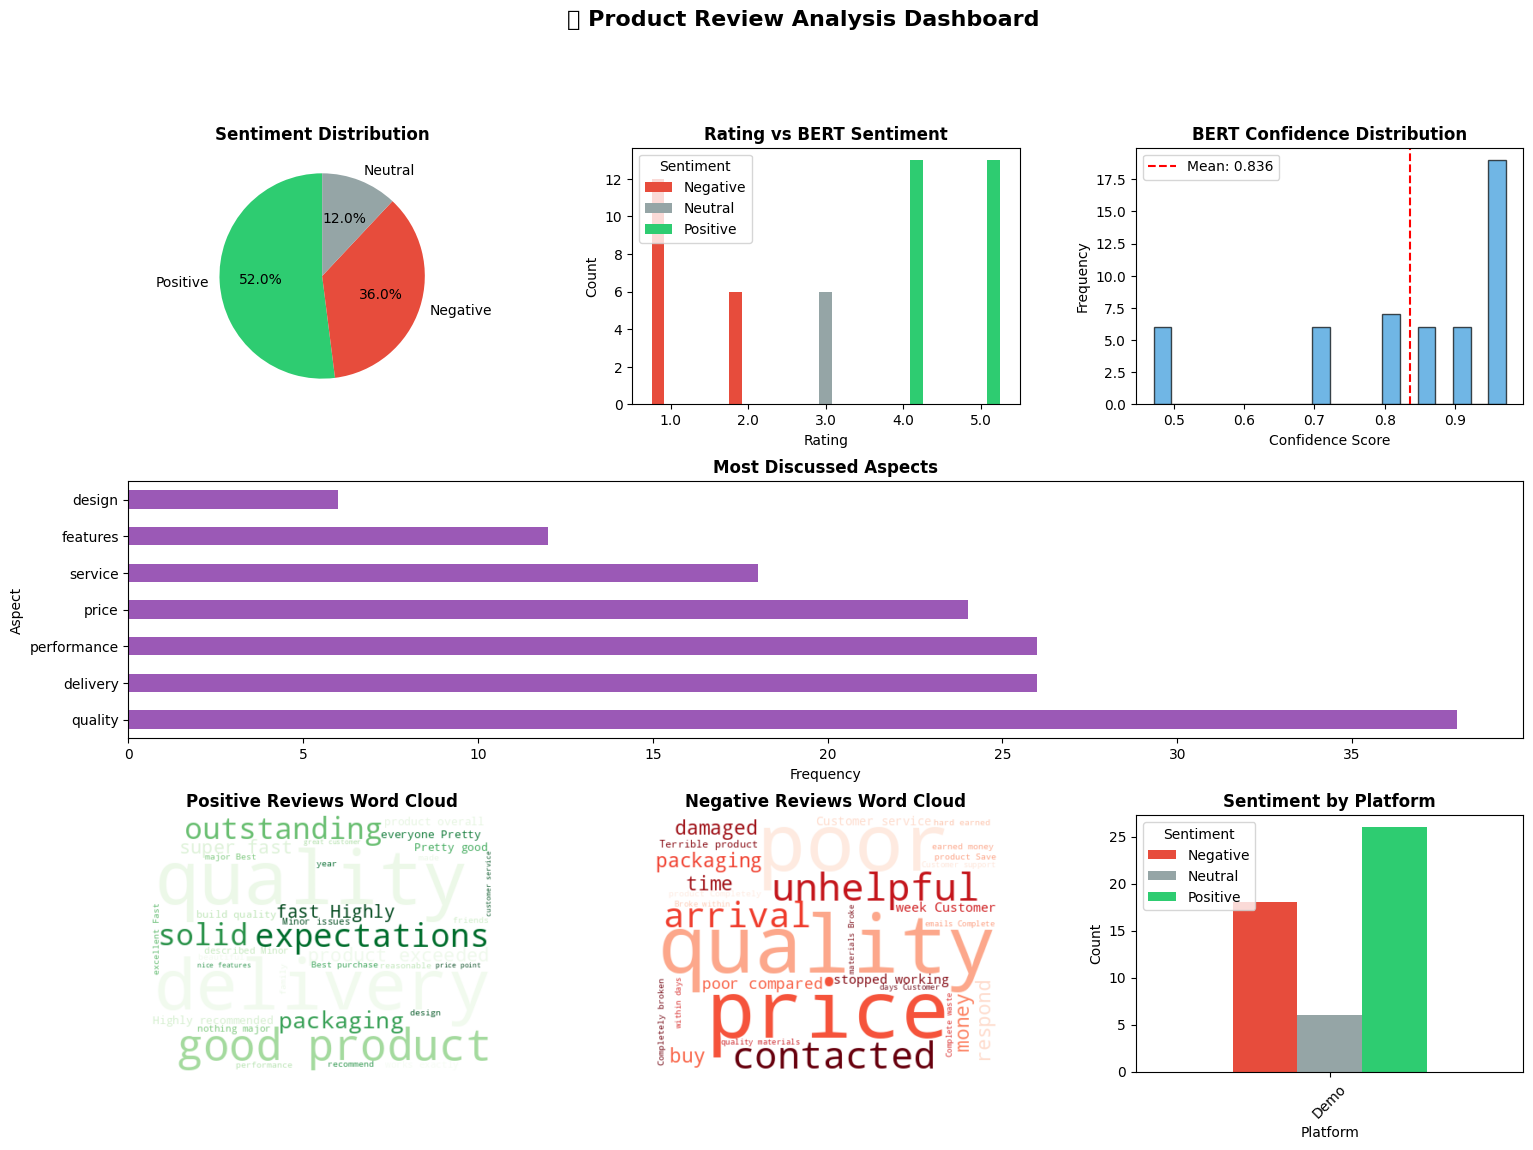

✅ Visualizations created!

💾 STEP 7: Exporting Results
----------------------------------------------------------------------
✅ Exported to review_analysis.csv
❌ Error exporting to JSON: Object of type int64 is not JSON serializable
✅ Exported summary report to summary_report.txt

✅ ANALYSIS COMPLETE!
   rating                             title  \
0     5.0                Excellent Product!   
1     4.0              Good value for money   
2     2.0         Disappointed with quality   
3     1.0           Complete waste of money   
4     3.0  Average product, nothing special   

                                         review_text  verified platform  \
0  This product exceeded my expectations. The qua...      True     Demo   
1  Pretty good product overall. The build quality...      True     Demo   
2  The product quality is poor compared to the pr...      True     Demo   
3  Terrible product. Completely broken on arrival...     False     Demo   
4  Its okay, nothing special about this

In [ ]:
# Quick Start - Complete Analysis
product_url = "https://amzn.in/d/4oQztnZ"
df_reviews, df_aspects, analytics = run_complete_analysis(product_url, max_reviews=30)

# Display results
print(df_reviews.head())
print(analytics.generate_summary_report())